# Store Item Demand Forecasting Challenge

## Seasonal Autoregressive Integrated Moving Average (SARIMA)

<a href="https://www.kaggle.com/c/demand-forecasting-kernels-only">Link to competition on Kaggle.</a>

SARIMA is a variant on the <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">ARIMA</a> model for datasets with a suspected seasonal effect.

In [24]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

pd.options.display.max_columns = 99
plt.rcParams['figure.figsize'] = (12, 8)

## Load Data

In [2]:
df_train = pd.read_csv('data/train.csv', parse_dates=['date'], index_col=['date'])
df_test = pd.read_csv('data/test.csv', parse_dates=['date'], index_col=['date'])
df_train.shape, df_test.shape

((913000, 3), (45000, 3))

In [3]:
df_train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


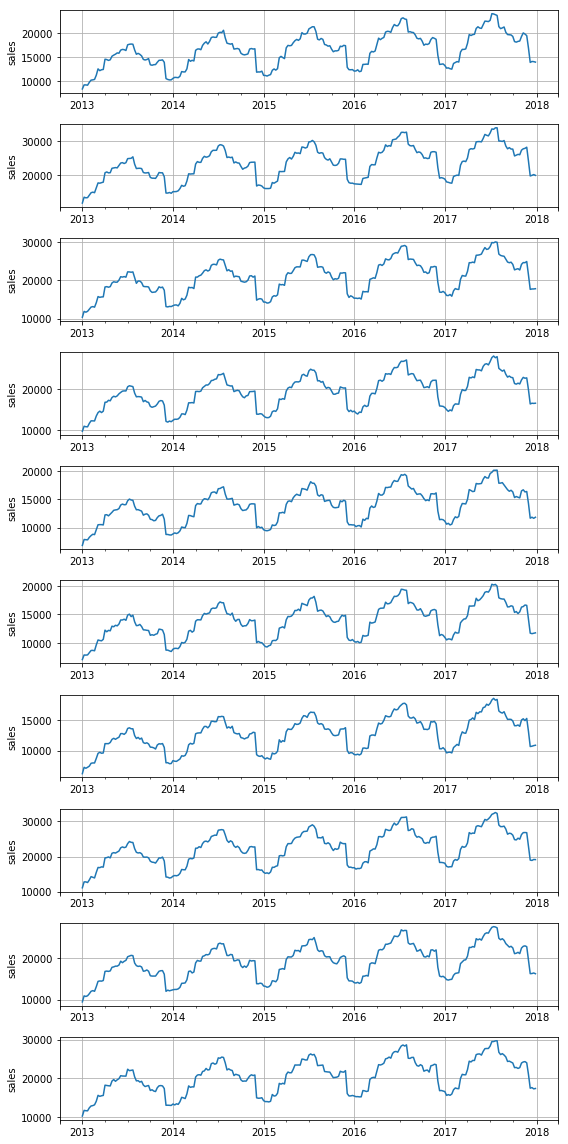

In [4]:
num_stores = len(df_train['store'].unique())
fig, axes = plt.subplots(num_stores, figsize=(8, 16))

for s in df_train['store'].unique():
    t = df_train.loc[df_train['store'] == s, 'sales'].resample('W').sum()
    ax = t.plot(ax=axes[s-1])
    ax.grid()
    ax.set_xlabel('')
    ax.set_ylabel('sales')
fig.tight_layout();

All stores appear to show identical trends and seasonality; they just differ in scale.

## SARIMA

We will build a SARIMA model for a single store and item, and then retrain it and generate predictions for all time series in the dataset.

### Example store and item

In [5]:
s1i1 = df_train.loc[(df_train['store'] == 1) & (df_train['item'] == 1)]
s1i1.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


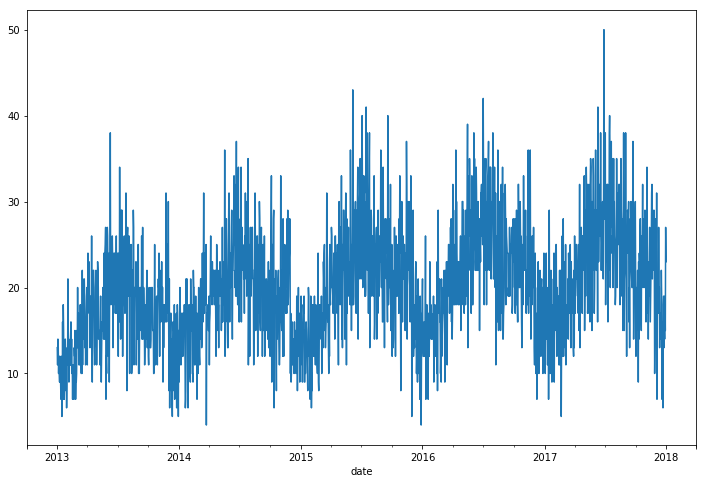

In [25]:
s1i1['sales'].plot();

### Time Series Decomposition

Decompose the example time series into trend, seasonal, and residual components.


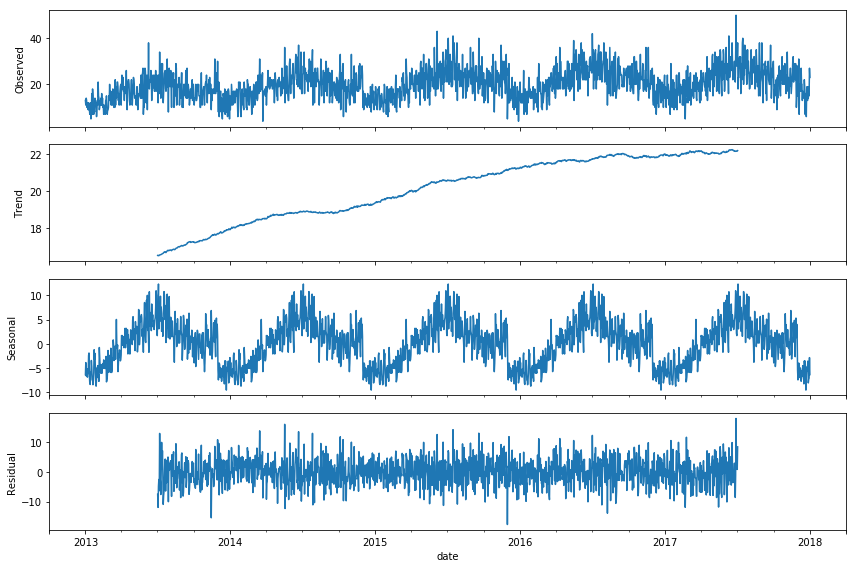

In [26]:
fig = seasonal_decompose(s1i1['sales'], model='additive', freq=365).plot()

There is clearly yearly seasonality and a non-stationary, upward trend. We can run a Dickey-Fuller test to examine the stationarity.

In [8]:
dftest = adfuller(s1i1['sales'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (5%)              -2.863145
Critical Value (1%)              -3.433984
Critical Value (10%)             -2.567625
dtype: float64

The Dickey-Fuller test p-value is lower than I would have expected, but the time series is not considered stationary using a 1% Critical Value and we can see visually that there is an upwards trend.

### Apply a seasonal difference

We should start by seeing if we can remove the trend by taking a seasonal difference.

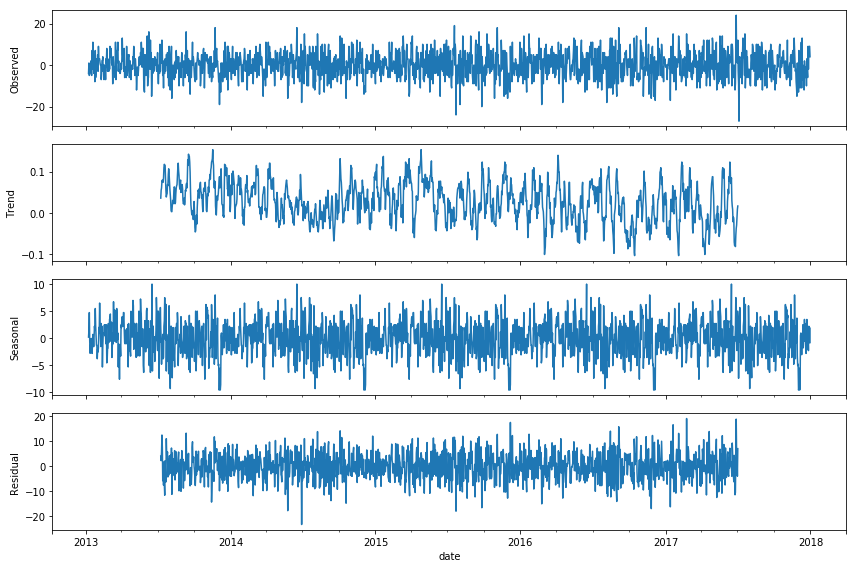

In [27]:
diff_7 = s1i1['sales'].diff(7)
diff_7.dropna(inplace=True)
fig = seasonal_decompose(diff_7, model='additive', freq=365).plot()

In [10]:
dftest = adfuller(diff_7, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -8.944407e+00
p-value                        9.070149e-15
#Lags Used                     2.400000e+01
Number of Observations Used    1.794000e+03
Critical Value (5%)           -2.863152e+00
Critical Value (1%)           -3.434000e+00
Critical Value (10%)          -2.567628e+00
dtype: float64

The Dickey-Fuller test suggests that the trend has been removed, although we can still see visually that there appears to be a trend. We can try and eliminate this by applying a further first difference.

### Take first differences

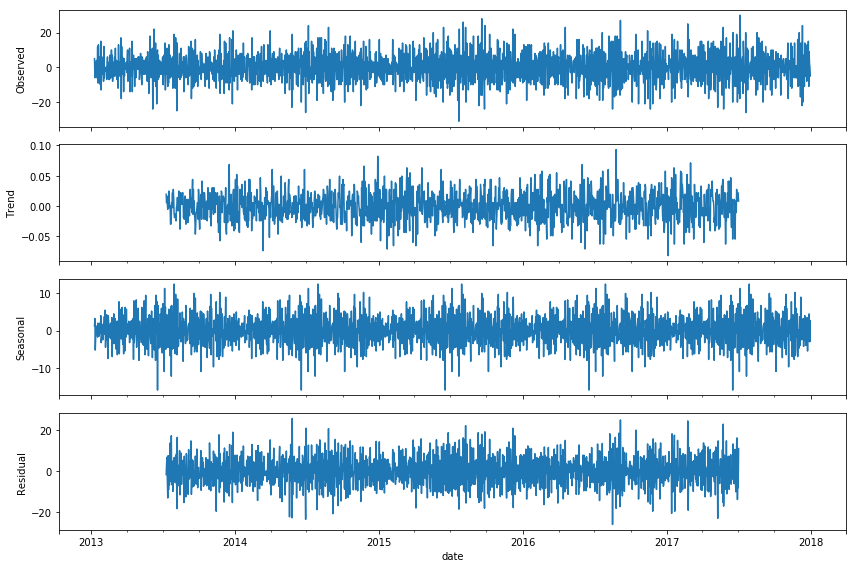

In [28]:
diff_1_7 = diff_7.diff(1)
diff_1_7.dropna(inplace=True)
fig = seasonal_decompose(diff_1_7, model='additive', freq=365).plot()

In [12]:
dftest = adfuller(diff_1_7, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.762274e+01
p-value                        3.831626e-30
#Lags Used                     2.500000e+01
Number of Observations Used    1.792000e+03
Critical Value (5%)           -2.863154e+00
Critical Value (1%)           -3.434004e+00
Critical Value (10%)          -2.567629e+00
dtype: float64

Clearly the trend has now been eliminated.

### Plot ACF and PACF

The <a href="https://en.wikipedia.org/wiki/Autocorrelation">Autocorrelation Function</a> (ACF) is the correlation of a signal with a delayed copy of itself as a function of delay.

The <a href="https://en.wikipedia.org/wiki/Partial_autocorrelation_function">Partial Autocorrelation Function</a> (PACF) is the partial correlation of a signal with a delayed copy of itself, controlling for the values of the time series at all shorter delays, as a function of delay.

Using the ACF and PACF, and some <a href="http://people.duke.edu/~rnau/arimrule.htm">simple heuristics</a>, the approriate Autoregression (AR) and Moving Average (MA) values can be identified for the SARIMA model. These are explained below.

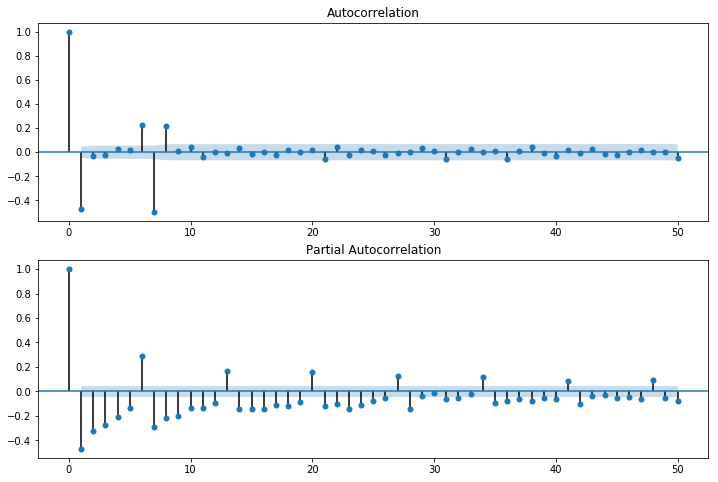

In [29]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(diff_1_7, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(diff_1_7, lags=50, ax=ax[1])

From the ACF, one non-seasonal MA term looks sensible. From the PACF, six non-seasonal AR terms looks sensible.

From the ACF, one seasonal MA term looks sensible. From the PACF, we could use multiple seasonal AR terms, but will use one to keep the training time reasonable.

### Build Model

From the above analysis, we have identified the following parameters for our seasonal ARIMA(p,d,q)(P,D,Q)m model:
- <b>p</b>: 6
- <b>d</b>: 1
- <b>q</b>: 1
- <b>P</b>: 1
- <b>D</b>: 1
- <b>Q</b>: 1
- <b>m</b>: 7

In [34]:
sarima = sm.tsa.statespace.SARIMAX(s1i1['sales'], trend='n', freq='D', enforce_invertibility=False,
                                   order=(6, 1, 1), seasonal_order=(1, 1, 1, 7))
results = sarima.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1826
Model:             SARIMAX(6, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -5393.681
Date:                           Sat, 25 Aug 2018   AIC                          10807.362
Time:                                   09:55:25   BIC                          10862.416
Sample:                               01-01-2013   HQIC                         10827.674
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0050      0.035      0.145      0.885      -0.063       0.073
ar.L2         -0.0292      0.031     -0.941

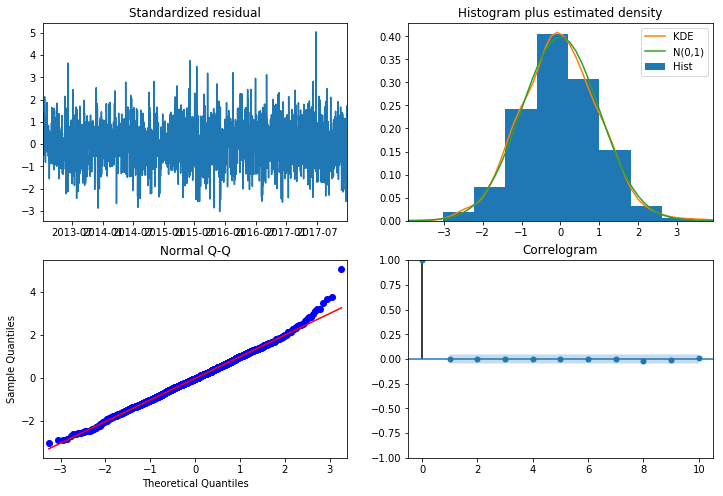

In [37]:
fig = results.plot_diagnostics()

## Make Predictions

In [16]:
sarima_results = df_test.reset_index()
sarima_results['sales'] = 0

In [17]:
tic = time.time()

for s in sarima_results['store'].unique():
    for i in sarima_results['item'].unique():
        si = df_train.loc[(df_train['store'] == s) & (df_train['item'] == i), 'sales']
        sarima = sm.tsa.statespace.SARIMAX(si, trend='n', freq='D', enforce_invertibility=False,
                                           order=(6, 1, 1), seasonal_order=(1, 1, 1, 7))
        results = sarima.fit()
        fcst = results.predict(start='2018-01-01', end='2018-03-31', dynamic=True)
        sarima_results.loc[(sarima_results['store'] == s) & (sarima_results['item'] == i), 'sales'] = fcst.values
        
        toc = time.time()
        if i % 10 == 0:
            print("Completed store {} item {}. Cumulative time: {:.1f}s".format(s, i, toc-tic))

Completed store 1 item 10. Cumulative time: 74.7s
Completed store 1 item 20. Cumulative time: 143.0s
Completed store 1 item 30. Cumulative time: 221.7s
Completed store 1 item 40. Cumulative time: 293.7s
Completed store 1 item 50. Cumulative time: 362.8s
Completed store 2 item 10. Cumulative time: 429.8s
Completed store 2 item 20. Cumulative time: 509.9s
Completed store 2 item 30. Cumulative time: 595.7s
Completed store 2 item 40. Cumulative time: 666.0s
Completed store 2 item 50. Cumulative time: 726.3s
Completed store 3 item 10. Cumulative time: 793.5s
Completed store 3 item 20. Cumulative time: 862.5s


C:\Users\aidan\Anaconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 3 item 30. Cumulative time: 933.5s
Completed store 3 item 40. Cumulative time: 996.4s
Completed store 3 item 50. Cumulative time: 1065.2s
Completed store 4 item 10. Cumulative time: 1135.7s
Completed store 4 item 20. Cumulative time: 1199.5s


C:\Users\aidan\Anaconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 4 item 30. Cumulative time: 1272.9s
Completed store 4 item 40. Cumulative time: 1343.5s
Completed store 4 item 50. Cumulative time: 1415.7s


C:\Users\aidan\Anaconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 5 item 10. Cumulative time: 1489.0s
Completed store 5 item 20. Cumulative time: 1559.0s
Completed store 5 item 30. Cumulative time: 1645.7s
Completed store 5 item 40. Cumulative time: 1720.2s
Completed store 5 item 50. Cumulative time: 1808.9s
Completed store 6 item 10. Cumulative time: 1888.1s
Completed store 6 item 20. Cumulative time: 1964.6s
Completed store 6 item 30. Cumulative time: 2046.7s
Completed store 6 item 40. Cumulative time: 2129.2s
Completed store 6 item 50. Cumulative time: 2207.8s
Completed store 7 item 10. Cumulative time: 2287.8s


C:\Users\aidan\Anaconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 7 item 20. Cumulative time: 2374.3s
Completed store 7 item 30. Cumulative time: 2451.6s
Completed store 7 item 40. Cumulative time: 2529.6s
Completed store 7 item 50. Cumulative time: 2604.5s
Completed store 8 item 10. Cumulative time: 2681.8s


C:\Users\aidan\Anaconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 8 item 20. Cumulative time: 2757.9s
Completed store 8 item 30. Cumulative time: 2832.0s
Completed store 8 item 40. Cumulative time: 2909.0s


C:\Users\aidan\Anaconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 8 item 50. Cumulative time: 2989.7s
Completed store 9 item 10. Cumulative time: 3069.3s
Completed store 9 item 20. Cumulative time: 3143.3s
Completed store 9 item 30. Cumulative time: 3225.9s
Completed store 9 item 40. Cumulative time: 3299.2s
Completed store 9 item 50. Cumulative time: 3374.1s
Completed store 10 item 10. Cumulative time: 3440.4s
Completed store 10 item 20. Cumulative time: 3513.6s
Completed store 10 item 30. Cumulative time: 3587.2s


C:\Users\aidan\Anaconda3\envs\ds\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Completed store 10 item 40. Cumulative time: 3668.0s
Completed store 10 item 50. Cumulative time: 3741.2s


In [18]:
sarima_results.drop(['date', 'store', 'item'], axis=1, inplace=True)
sarima_results.head()

,id,sales
0,0,12.436975
1,1,15.124433
2,2,15.749205
3,3,16.828276
4,4,17.950068


In [19]:
sarima_results.to_csv('sarima_results.csv', index=False)

Scores 15.77934 on the leaderboard.

### Example forecast

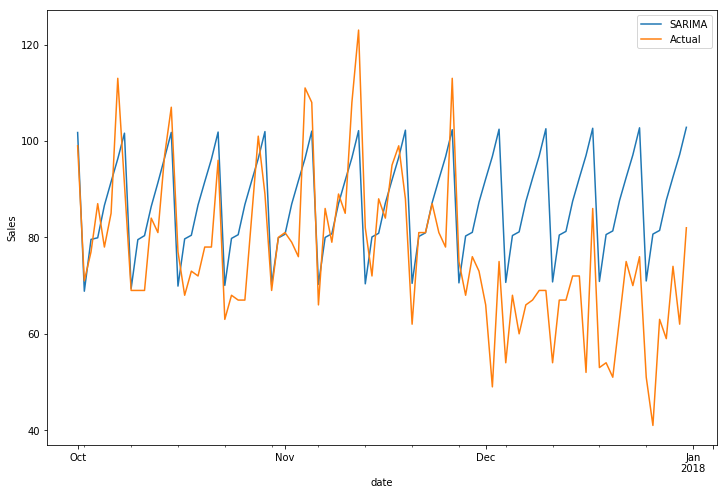

In [33]:
forecast = results.predict(start='2017-10-01', end='2017-12-31', dynamic=True)
actual = df_train.loc[(df_train['store'] == 10) & (df_train['item'] == 50), 'sales']

forecast.plot()
actual.loc['2017-10-01':].plot()
plt.legend(['SARIMA', 'Actual'])
plt.ylabel('Sales');